In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import warnings
import time
from tqdm import trange

warnings.filterwarnings('ignore')

In [29]:
# Load Data
train_raw = pd.read_csv('../Data/KDDCUP99/train.csv')
print(train_raw.shape)
test_raw = pd.read_csv('../Data/KDDCUP99/test.csv')
print(test_raw.shape)

# Seperate label and Drop ID
def LabelEncode(x):
    if x == 'normal.':
        return 0
    else:
        return 1
train_X = train_raw.drop(['type'], axis=1).select_dtypes(include='number')
print(train_X.shape)
train_Y = train_raw['type'].apply(LabelEncode)
test_X = test_raw.drop(['type'], axis=1).select_dtypes(include='number')
print(test_X.shape)
test_Y = test_raw['type'].apply(LabelEncode)

# Normalize data with min, max of training data
test_X1 = (test_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
train_X1 = (train_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))

test_X1[test_X1 < 0] = 0
test_X1[test_X1 > 1] = 1

train_X1.fillna(0, inplace=True)
test_X1.fillna(0, inplace=True)

(494021, 42)
(311029, 42)
(494021, 38)
(311029, 38)


In [30]:
# correlation based feature selection
corr = train_X1.corr().abs()

threshold = 0.8
corr.values[np.tril_indices_from(corr.values)] = np.nan
redundant = []
for j in corr.columns:
    for i in corr.index:
        if corr.loc[i, j] > threshold:
            redundant.append((i, j))

train_X2 = train_X1.copy()
train_X2['type'] = train_Y
corr2 = train_X2.corr().abs()

corr3 = corr2['type'].iloc[:-1].copy()
drop = []

#! modify
for i, j in redundant:
    if corr3[i] > corr3[j]:
        if j not in drop:
            drop.append(j)
    elif i not in drop:
        drop.append(i)
print(drop)

train_X1 = train_X1.drop(drop, axis=1)
test_X1 = test_X1.drop(drop, axis=1)
print(train_X1.shape)
print(test_X1.shape)

['num_compromised', 'hot', 'srv_count', 'srv_serror_rate', 'srv_rerror_rate', 'serror_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'rerror_rate']
(494021, 25)
(311029, 25)


In [13]:
from sklearn.feature_selection import SelectKBest, SelectFromModel, RFE, SequentialFeatureSelector, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [32]:
# select 1 best feature iteratively with chi2, ANOVA, mutual info

subset_all = []
for sf in [chi2, f_classif, mutual_info_classif]:
    cols = []
    selector = SelectKBest(sf, k=1)
    for k in trange(train_X1.shape[1]):
        # select one best feature and add it to subset
        selector.fit(train_X1.drop(cols, axis=1), train_Y)
        f = selector.get_feature_names_out(train_X1.columns.drop(cols))
        cols.append(f[0])
    subset_all.append(cols)
    print(cols)

100%|██████████| 25/25 [00:02<00:00, 11.18it/s]


['logged_in', 'count', 'srv_diff_host_rate', 'dst_host_count', 'same_srv_rate', 'dst_host_srv_diff_host_rate', 'dst_host_diff_srv_rate', 'duration', 'is_guest_login', 'wrong_fragment', 'num_access_files', 'dst_bytes', 'num_shells', 'num_file_creations', 'diff_srv_rate', 'su_attempted', 'num_root', 'root_shell', 'dst_host_srv_rerror_rate', 'land', 'urgent', 'src_bytes', 'num_failed_logins', 'is_host_login', 'num_outbound_cmds']


100%|██████████| 25/25 [00:02<00:00, 11.22it/s]


['logged_in', 'count', 'dst_host_count', 'srv_diff_host_rate', 'same_srv_rate', 'dst_host_srv_diff_host_rate', 'duration', 'dst_host_diff_srv_rate', 'num_access_files', 'dst_bytes', 'is_guest_login', 'wrong_fragment', 'num_file_creations', 'diff_srv_rate', 'num_shells', 'num_root', 'su_attempted', 'root_shell', 'dst_host_srv_rerror_rate', 'land', 'urgent', 'num_failed_logins', 'src_bytes', 'is_host_login', 'num_outbound_cmds']


100%|██████████| 25/25 [15:33<00:00, 37.33s/it]

['count', 'src_bytes', 'dst_bytes', 'dst_host_count', 'logged_in', 'dst_host_srv_diff_host_rate', 'dst_host_diff_srv_rate', 'srv_diff_host_rate', 'same_srv_rate', 'diff_srv_rate', 'duration', 'dst_host_srv_rerror_rate', 'num_root', 'num_access_files', 'is_guest_login', 'num_file_creations', 'urgent', 'land', 'root_shell', 'wrong_fragment', 'num_shells', 'is_host_login', 'su_attempted', 'num_outbound_cmds', 'num_failed_logins']


In [33]:
# select 1 best feature iteratively with SFS, using RF, LR
for model in [RandomForestClassifier(random_state=0, n_jobs=-1), LogisticRegression(max_iter=10000, random_state=0, n_jobs=-1)]:
    cols = []
    selector = SequentialFeatureSelector(model, n_features_to_select=1, scoring='f1', cv=5, n_jobs=-1)
    for k in trange(train_X1.shape[1]-1):
        selector.fit(train_X1.drop(cols, axis=1), train_Y)
        f = train_X1.columns.drop(cols)[selector.get_support()]
        cols.append(f[0])
    cols.append(train_X1.columns.drop(cols)[0])
    subset_all.append(cols)
    print(cols)
print(len(subset_all))

100%|██████████| 24/24 [34:22<00:00, 85.93s/it]  


['count', 'dst_bytes', 'logged_in', 'dst_host_count', 'dst_host_srv_diff_host_rate', 'srv_diff_host_rate', 'dst_host_diff_srv_rate', 'duration', 'src_bytes', 'same_srv_rate', 'num_root', 'num_access_files', 'num_file_creations', 'num_shells', 'su_attempted', 'land', 'wrong_fragment', 'root_shell', 'num_outbound_cmds', 'is_host_login', 'urgent', 'num_failed_logins', 'is_guest_login', 'diff_srv_rate', 'dst_host_srv_rerror_rate']


100%|██████████| 24/24 [03:41<00:00,  9.23s/it]

['count', 'logged_in', 'dst_host_count', 'srv_diff_host_rate', 'dst_host_srv_diff_host_rate', 'duration', 'num_access_files', 'dst_bytes', 'num_shells', 'num_file_creations', 'su_attempted', 'num_root', 'src_bytes', 'land', 'wrong_fragment', 'urgent', 'root_shell', 'num_outbound_cmds', 'is_host_login', 'same_srv_rate', 'diff_srv_rate', 'num_failed_logins', 'is_guest_login', 'dst_host_diff_srv_rate', 'dst_host_srv_rerror_rate']
5


In [34]:
# select 1 best feature iteratively with importance, using RF, LR
for model in [RandomForestClassifier(random_state=0, n_jobs=-1), LogisticRegression(max_iter=10000, random_state=0, n_jobs=-1)]:
    cols = []
    selector = SelectFromModel(model, threshold=-np.inf, max_features=1)
    for k in trange(train_X1.shape[1]-1):
        selector.fit(train_X1.drop(cols, axis=1), train_Y)
        f = train_X1.columns.drop(cols)[selector.get_support()]
        cols.append(f[0])
    cols.append(train_X1.columns.drop(cols)[0])
    subset_all.append(cols)
    print(cols)

100%|██████████| 24/24 [01:07<00:00,  2.79s/it]


['count', 'dst_bytes', 'logged_in', 'dst_host_count', 'dst_host_srv_diff_host_rate', 'srv_diff_host_rate', 'dst_host_diff_srv_rate', 'duration', 'same_srv_rate', 'diff_srv_rate', 'dst_host_srv_rerror_rate', 'src_bytes', 'num_root', 'num_access_files', 'num_file_creations', 'is_guest_login', 'wrong_fragment', 'num_shells', 'su_attempted', 'num_failed_logins', 'root_shell', 'urgent', 'land', 'num_outbound_cmds', 'is_host_login']


100%|██████████| 24/24 [00:52<00:00,  2.17s/it]

['wrong_fragment', 'count', 'duration', 'dst_host_srv_diff_host_rate', 'same_srv_rate', 'root_shell', 'logged_in', 'num_access_files', 'land', 'srv_diff_host_rate', 'dst_host_count', 'dst_bytes', 'num_file_creations', 'num_shells', 'dst_host_diff_srv_rate', 'su_attempted', 'num_root', 'is_guest_login', 'diff_srv_rate', 'dst_host_srv_rerror_rate', 'urgent', 'num_failed_logins', 'src_bytes', 'num_outbound_cmds', 'is_host_login']


In [35]:
# save selected feature sets to csv file
pd.DataFrame(subset_all, index=['chi2', 'ANOVA', 'mutualinfo', 'sfs(rf)', 'sfs(lr)', 'im(rf)', 'im(lr)']).to_csv('../Results/KDDCUP99/Feature_sets.csv')

In [36]:
# measure performance by cv(f1 score)
cv_times_all = []
f1_all = []
model = LogisticRegression(max_iter=10000, random_state=0, n_jobs=-1)
for i in range(len(subset_all)):
    cv_times = []
    f1s = []
    for k in trange(1, train_X1.shape[1]):
        # cross validation
        second = time.time()
        cv = cross_val_score(model, train_X1[subset_all[i][1:k+1]], train_Y, scoring='f1', n_jobs=-1)
        second2 = time.time()
        cv_times.append(second2 - second)
        f1s.append((cv.mean(), cv.std()))
    
    cv_times_all.append(cv_times)
    f1_all.append(f1s)

100%|██████████| 25/25 [02:03<00:00,  4.95s/it]


In [37]:
pd.DataFrame(cv_times_all, index=['chi2', 'ANOVA', 'mutualinfo', 'sfs(rf)', 'sfs(lr)', 'im(rf)', 'im(lr)']).to_csv('../Results/KDDCUP99/Time_LR.csv')
pd.DataFrame(f1_all, index=['chi2', 'ANOVA', 'mutualinfo', 'sfs(rf)', 'sfs(lr)', 'im(rf)', 'im(lr)']).to_csv('../Results/KDDCUP99/F1_LR.csv')

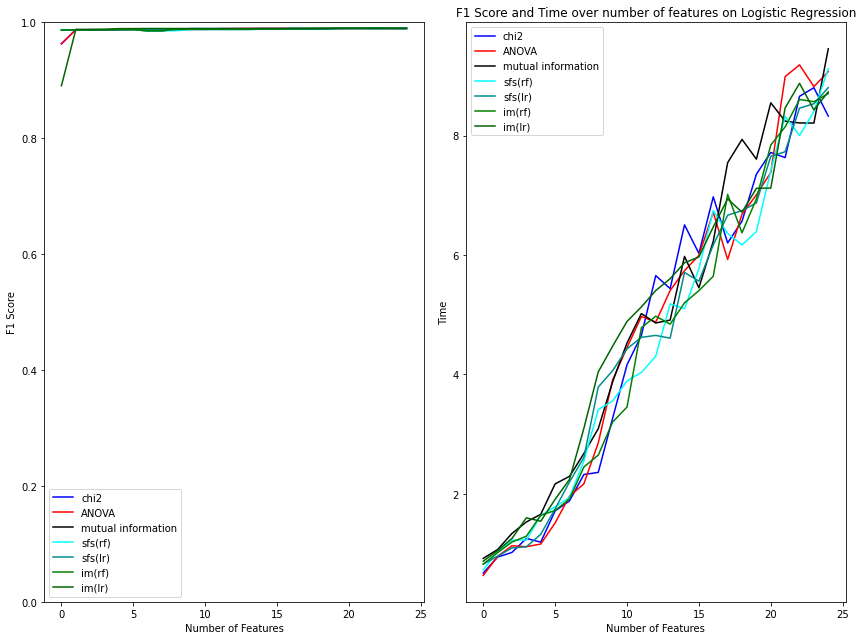

In [38]:
fig, axis = plt.subplots(1, 2, figsize=(12, 9))

plt.title('F1 Score and Time over number of features on Logistic Regression', loc='center')
plt.subplot(1, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(train_X1.shape[1]), np.array(f1_all)[0,:,0], color='blue', linestyle='-', label='chi2')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[1,:,0], color='red', linestyle='-', label='ANOVA')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[2,:,0], color='black', linestyle='-', label='mutual information')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[3,:,0], color='cyan', linestyle='-', label='sfs(rf)')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[4,:,0], color='darkcyan', linestyle='-', label='sfs(lr)')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[5,:,0], color='green', linestyle='-', label='im(rf)')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[6,:,0], color='darkgreen', linestyle='-', label='im(lr)')

plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(train_X1.shape[1]), cv_times_all[0], color='blue', linestyle='-', label='chi2')
plt.plot(range(train_X1.shape[1]), cv_times_all[1], color='red', linestyle='-', label='ANOVA')
plt.plot(range(train_X1.shape[1]), cv_times_all[2], color='black', linestyle='-', label='mutual information')
plt.plot(range(train_X1.shape[1]), cv_times_all[3], color='cyan', linestyle='-', label='sfs(rf)')
plt.plot(range(train_X1.shape[1]), cv_times_all[4], color='darkcyan', linestyle='-', label='sfs(lr)')
plt.plot(range(train_X1.shape[1]), cv_times_all[5], color='green', linestyle='-', label='im(rf)')
plt.plot(range(train_X1.shape[1]), cv_times_all[6], color='darkgreen', linestyle='-', label='im(lr)')

plt.legend()

plt.tight_layout()
plt.show()

In [39]:
cv_times_all = []
f1_all = []

model = GradientBoostingClassifier(random_state=0)
for i in range(len(subset_all)):
    cv_times = []
    f1s = []
    for k in trange(1, train_X1.shape[1]):
        # cross validation
        second = time.time()
        cv = cross_val_score(model, train_X1[subset_all[i][1:k+1]], train_Y, scoring='f1', n_jobs=-1)
        second2 = time.time()
        cv_times.append(second2 - second)
        f1s.append((cv.mean(), cv.std()))
    
    cv_times_all.append(cv_times)
    f1_all.append(f1s)

100%|██████████| 25/25 [08:45<00:00, 21.02s/it]


In [40]:
pd.DataFrame(cv_times_all, index=['chi2', 'ANOVA', 'mutualinfo', 'sfs(rf)', 'sfs(lr)', 'im(rf)', 'im(lr)']).to_csv('../Results/KDDCUP99/Time_GB.csv')
pd.DataFrame(f1_all, index=['chi2', 'ANOVA', 'mutualinfo', 'sfs(rf)', 'sfs(lr)', 'im(rf)', 'im(lr)']).to_csv('../Results/KDDCUP99/F1_GB.csv')

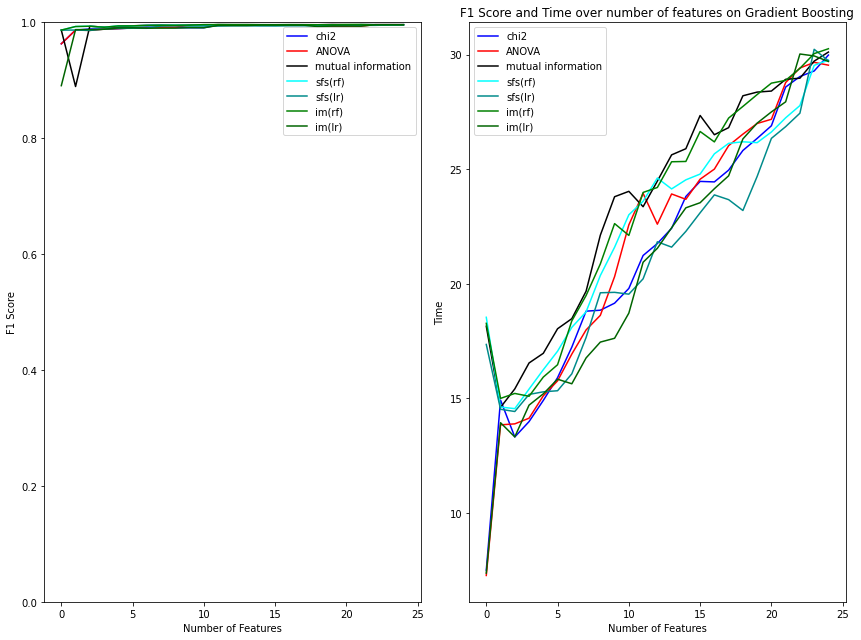

In [41]:
fig, axis = plt.subplots(1, 2, figsize=(12, 9))

plt.title('F1 Score and Time over number of features on Gradient Boosting', loc='center')
plt.subplot(1, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(train_X1.shape[1]), np.array(f1_all)[0,:,0], color='blue', linestyle='-', label='chi2')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[1,:,0], color='red', linestyle='-', label='ANOVA')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[2,:,0], color='black', linestyle='-', label='mutual information')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[3,:,0], color='cyan', linestyle='-', label='sfs(rf)')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[4,:,0], color='darkcyan', linestyle='-', label='sfs(lr)')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[5,:,0], color='green', linestyle='-', label='im(rf)')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[6,:,0], color='darkgreen', linestyle='-', label='im(lr)')

plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(train_X1.shape[1]), cv_times_all[0], color='blue', linestyle='-', label='chi2')
plt.plot(range(train_X1.shape[1]), cv_times_all[1], color='red', linestyle='-', label='ANOVA')
plt.plot(range(train_X1.shape[1]), cv_times_all[2], color='black', linestyle='-', label='mutual information')
plt.plot(range(train_X1.shape[1]), cv_times_all[3], color='cyan', linestyle='-', label='sfs(rf)')
plt.plot(range(train_X1.shape[1]), cv_times_all[4], color='darkcyan', linestyle='-', label='sfs(lr)')
plt.plot(range(train_X1.shape[1]), cv_times_all[5], color='green', linestyle='-', label='im(rf)')
plt.plot(range(train_X1.shape[1]), cv_times_all[6], color='darkgreen', linestyle='-', label='im(lr)')

plt.legend()

plt.tight_layout()
plt.show()

In [42]:
from keras import Sequential, layers, optimizers, losses, metrics, callbacks
from sklearn.model_selection import StratifiedKFold

In [43]:
def ModelCreate(input_shape):
    model = Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])
    return model

In [44]:
cv_times_all = []
f1_all = []

kf = StratifiedKFold(shuffle=True, random_state=0)
callback = callbacks.EarlyStopping(patience=3, min_delta=0.1, restore_best_weights=True)
for i in range(len(subset_all)):
    cv_times = []
    f1s = []
    for k in trange(1, train_X1.shape[1]):
        model = ModelCreate((k+1,))
        # cross validation
        j = 0
        cv_time = 0
        cv = np.zeros(shape=5)
        train_X2 = train_X1[subset_all[i]1[:k+1]].copy()
        for train_index, test_index in kf.split(train_X2, train_Y):
            x_train_fold, x_test_fold = train_X2.iloc[train_index, :], train_X2.iloc[test_index, :]
            y_train_fold, y_test_fold = train_Y.iloc[train_index], train_Y.iloc[test_index]

            second = time.time()
            model.fit(x_train_fold.values, y_train_fold.values, validation_data=(x_test_fold, y_test_fold), epochs=30, callbacks=[callback], use_multiprocessing=True, verbose=0)
            predict = model.predict(x_test_fold, use_multiprocessing=True)
            predict = np.where(predict < 0.5, 0, 1)
            cv[j] = f1_score(y_test_fold, predict)
            second2 = time.time()
            cv_time += second2 - second
            j += 1
        cv_times.append(cv_time)
        f1s.append((cv.mean(), cv.std()))
    
    cv_times_all.append(cv_times)
    f1_all.append(f1s)

100%|██████████| 25/25 [7:25:51<00:00, 1070.05s/it]  


In [45]:
pd.DataFrame(cv_times_all, index=['chi2', 'ANOVA', 'mutualinfo', 'sfs(rf)', 'sfs(lr)', 'im(rf)', 'im(lr)']).to_csv('../Results/KDDCUP99/Time_DNN.csv')
pd.DataFrame(f1_all, index=['chi2', 'ANOVA', 'mutualinfo', 'sfs(rf)', 'sfs(lr)', 'im(rf)', 'im(lr)']).to_csv('../Results/KDDCUP99/F1_DNN.csv')

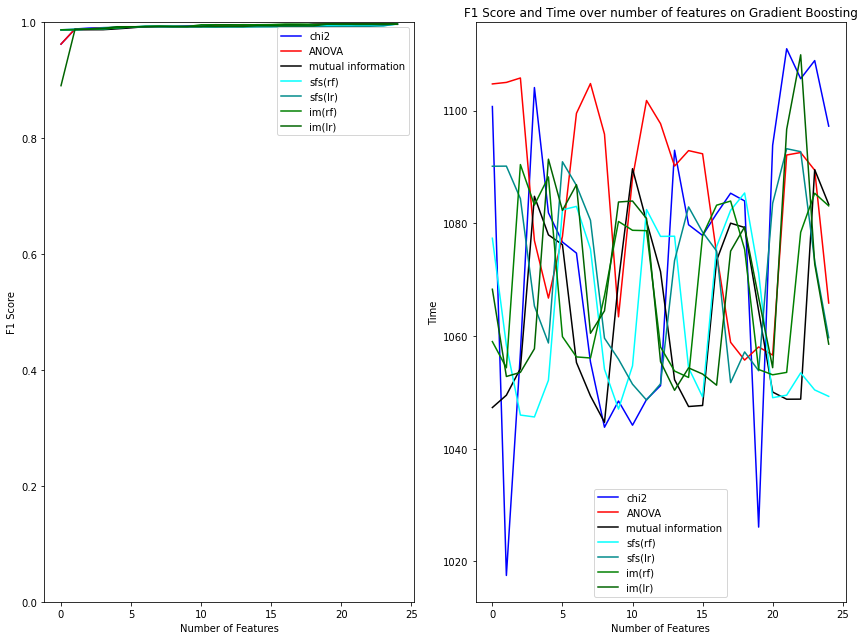

In [46]:
fig, axis = plt.subplots(1, 2, figsize=(12, 9))

plt.title('F1 Score and Time over number of features on Gradient Boosting', loc='center')
plt.subplot(1, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(train_X1.shape[1]), np.array(f1_all)[0,:,0], color='blue', linestyle='-', label='chi2')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[1,:,0], color='red', linestyle='-', label='ANOVA')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[2,:,0], color='black', linestyle='-', label='mutual information')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[3,:,0], color='cyan', linestyle='-', label='sfs(rf)')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[4,:,0], color='darkcyan', linestyle='-', label='sfs(lr)')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[5,:,0], color='green', linestyle='-', label='im(rf)')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[6,:,0], color='darkgreen', linestyle='-', label='im(lr)')

plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(train_X1.shape[1]), cv_times_all[0], color='blue', linestyle='-', label='chi2')
plt.plot(range(train_X1.shape[1]), cv_times_all[1], color='red', linestyle='-', label='ANOVA')
plt.plot(range(train_X1.shape[1]), cv_times_all[2], color='black', linestyle='-', label='mutual information')
plt.plot(range(train_X1.shape[1]), cv_times_all[3], color='cyan', linestyle='-', label='sfs(rf)')
plt.plot(range(train_X1.shape[1]), cv_times_all[4], color='darkcyan', linestyle='-', label='sfs(lr)')
plt.plot(range(train_X1.shape[1]), cv_times_all[5], color='green', linestyle='-', label='im(rf)')
plt.plot(range(train_X1.shape[1]), cv_times_all[6], color='darkgreen', linestyle='-', label='im(lr)')

plt.legend()

plt.tight_layout()
plt.show()